In [1]:
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

import random


from skimage.feature import hog

from sklearn.model_selection import train_test_split  ,GridSearchCV
from sklearn import datasets
from sklearn import svm


from joblib import dump, load

In [594]:
dump(clf, 'E:/anaconda3/envs/cnn/Vehicle detector/filename.joblib') 




['E:/anaconda3/envs/cnn/Vehicle detector/filename.joblib']

In [9]:
clf=load('E:/anaconda3/envs/cnn/Vehicle detector/filename.joblib')


In [3]:
cars_direc=r'E:/anaconda3/envs/cnn/Vehicle detector/vehicles/cars/'
non_cars_direc=r'E:/anaconda3/envs/cnn/Vehicle detector/non-vehicles/non_cars/'



cars=[]
non_cars=[]

dics=os.listdir(cars_direc)

for dic in dics:
    img=cv2.imread(cars_direc+dic)
    cars.append(img)

    
dics=os.listdir(non_cars_direc)

for dic in dics:
    img=cv2.imread(non_cars_direc+dic)
    non_cars.append(img)    

In [4]:
def hog_feature_extractor(imgs,oris,pixs,cells):
    
    features=[]
    hog_imgs=[]
    
    for img in imgs:
        
        if img.shape != (64,64,3) and (img.shape[0]== img.shape[1]):
            
            img=cv2.resize(img,(64,64,3))
            
            
        feature,hog_img = hog( image=img, orientations=oris, pixels_per_cell=(pixs,pixs), cells_per_block= (cells,cells), visualize=True, multichannel=True)
        features.append(feature)
        hog_imgs.append(hog_img)
        
    return features , hog_imgs

In [5]:
car_features     , car_hog_imgs     = hog_feature_extractor(cars,9,8,2)
non_car_features , non_car_hog_imgs = hog_feature_extractor(non_cars,9,8,2)



In [6]:
print(non_car_features[0].shape)

(1764,)


In [7]:
data_len= len(car_features + non_car_features)
X=np.zeros((data_len,1764))
Y=np.zeros((data_len,))

i=0
for feature in car_features:
    X[i]=feature
    Y[i]=+1
    i+=1
    
for feature in non_car_features:
    X[i]=feature
    Y[i]=-1
    i+=1

In [ ]:
parameters = {'kernel':['rbf'], 'C':[4,7,10,13,20,30]}
svr = svm.SVC()


clf = GridSearchCV(svr, parameters,cv=10,scoring='accuracy', verbose=10)
clf.fit(X, Y)

In [10]:
clf.best_params_


{'C': 4, 'kernel': 'rbf'}

In [11]:
test_img_dic='E:/anaconda3/envs/cnn/Vehicle detector/test1.jpg'

test_img=cv2.imread(test_img_dic)

In [12]:
def get_windows(test_img,y_start,overlap):
    
    image=np.copy(test_img)
    
    window_1=64
    shift=int(window_1*overlap)
    
    img_region=image[y_start:450,:]
    
    n_shift_H=int(img_region.shape[1]/shift)
    n_shift_V=int(img_region.shape[0]/shift)
    
    boxes=[]
      
    for i in range (n_shift_V):
        
        for j in range (n_shift_H):
            
            start_point=[i*shift,j*shift]
            
            end_point  =[window_1+i*shift , window_1 + j*shift]
            
            
            img=img_region[i*shift:window_1+i*shift,j*shift:window_1+ j*shift]
            
            boxes.append([img,start_point,end_point])
            
            
          
    window_2=128
    shift=int(window_2*overlap)
    
    img_region=image[y_start:520,:]
    
    n_shift_H=int(img_region.shape[1]/shift)
    n_shift_V=int(img_region.shape[0]/shift)
    
    
    for i in range (n_shift_V):
        
        for j in range (n_shift_H):
            
            start_point=[i*shift,j*shift]
            
            end_point  =[window_2+i*shift , window_2 + j*shift]
            
            
            img=img_region[i*shift:window_2+i*shift,j*shift:window_2+ j*shift]
            
            boxes.append([img,start_point,end_point])
           
    window_3=256
    shift=int(window_3*overlap)
    
    img_region=image[y_start:720,:]
    
    n_shift_H=int(img_region.shape[1]/shift)
    n_shift_V=int(img_region.shape[0]/shift)
    
    
    for i in range (n_shift_V):
        
        for j in range (n_shift_H):
            
            start_point=[i*shift,j*shift]
            
            end_point  =[window_3+i*shift , window_3 + j*shift]
            
            
            img=img_region[i*shift:window_3+i*shift,j*shift:window_3+ j*shift]
            
            boxes.append([img,start_point,end_point])
            
     
    window_4=512
    shift=int(window_4*overlap)
    
    img_region=image[y_start:720,:]
    
    n_shift_H=int(img_region.shape[1]/shift)
    n_shift_V=int(img_region.shape[0]/shift)
    
    
    for i in range (n_shift_V):
        
        for j in range (n_shift_H):
            
            start_point=[i*shift,j*shift]
            
            end_point  =[window_4+i*shift , window_4 + j*shift]
            
            
            img=img_region[i*shift:window_4+i*shift,j*shift:window_4+ j*shift]
            
            boxes.append([img,start_point,end_point])
            
      #for box in boxes:
        
      #  y_1=box[1][0]  +y_start
      #  y_2  =box[2][0]+y_start
        
       # x_1=box[1][1]
      #  x_2  =box[2][1]
        
       # r=random.randint(0,255)
       # g=random.randint(0,255)
       # b=random.randint(0,255)
       # color=(r, g, b)
        
       # img_new=cv2.rectangle(image,(x_1,y_1),(x_2,y_2),color ,6)
        
        
    #plt.imshow(img_new) 
      
    return boxes

In [13]:
boxes=get_windows(test_img,300,0.2)
x=boxes[0][0]
x=cv2.resize(x,(64,64))
print(x.shape)

(64, 64, 3)


In [14]:
def classify_boxes(boxes,clf):
    start_end_points=[]
    for box in boxes:
        
        img=box[0]
        
        if img.shape != (64,64,3):
            
            img=cv2.resize(img,(64,64))
            
        
        
        feature= hog( image=img, orientations=9, pixels_per_cell=(8,8), cells_per_block= (2,2), visualize=False, multichannel=True)
        feature=feature.reshape((1,1764))
        pred=clf.predict(feature)
        if pred==1 :
            
            start_end_points.append([box[1][0],box[1][1],box[2][0],box[2][1]])
            
    return start_end_points
            

In [30]:
def hot_box_voting(start_end_points,img_shape):
    
    hot_map=np.zeros(img_shape[0:2])
    
    for points in start_end_points:
        y_start=points[0]+300
        x_start=points[1]
        
        y_end  =points[2]+300
        x_end  =points[3]
        
        hot_map[y_start:y_end,x_start:x_end] += 1
    
    
    threshold=4
    hot_map[hot_map[:,:]<threshold]=0
    hot_map[hot_map[:,:]>=threshold]=255
    
    
    kernel = np.ones((51,51),np.uint8)

    hot_map=cv2.erode(hot_map,kernel)
    
    final=np.dstack((hot_map,np.zeros(img_shape[0:2]),np.zeros(img_shape[0:2])))
    return final

In [16]:
new_boxes=classify_boxes(boxes,clf)

In [31]:
hot_map=hot_box_voting(new_boxes,test_img.shape)
print(hot_map.shape)

(720, 1280, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


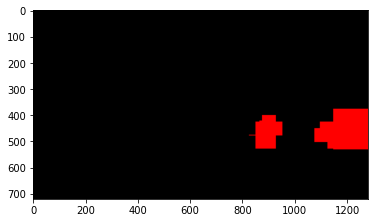

In [32]:
plt.imshow(hot_map)

In [33]:
tot=cv2.addWeighted(src1=test_img.astype(np.uint8),src2=hot_map.astype(np.uint8),alpha=0.5,beta=0.5,gamma=0)

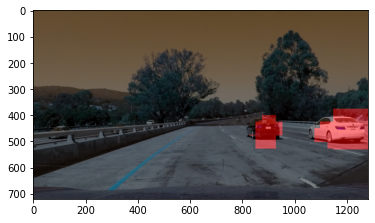

In [34]:
plt.imshow(tot)